In [ ]:
!nvidia-smi

Mon Apr 26 17:41:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U albumentations
!pip install tqdm

     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 952kB 19.6MB/s 
     |████████████████████████████████| 37.6MB 134kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12



Please change /usr/local/lib/python3.7/dist-packages/torchvision/models/mobilenetv2.py
```
    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1 => must use reshape with x.shape[0]
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x
```
change to
```
def _forward_impl(self, x: Tensor) -> Tensor:
    # This exists since TorchScript doesn't support inheritance, so the superclass method
    # (this one) needs to have a name other than `forward` that can be accessed in a subclass
    x = self.features(x)
    # Cannot use "squeeze" as batch-size can be 1
    x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x
```


In [ ]:
import numpy as np
import requests
from io import BytesIO
import cv2
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchvision import models as models
from tqdm.notebook import tqdm

##########onnx export#########

import torch.onnx
import torchvision

###################

import albumentations as A

from google.colab import drive


import random
random.seed(42)

In [ ]:
f = open('/content/drive/Shareddrives/ComputerVision/doodleDataset/50classList.txt','r')
categories = []
for l in f.readlines() :
  l = l.strip()
  l = l.replace("_"," ")
  categories.append(l)
f.close()
print(categories)

['alarm clock', 'anvil', 'apple', 'bat', 'bed', 'bucket', 'butterfly', 'camera', 'circle', 'cup', 'diamond', 'dog', 'dolphin', 'eye', 'finger', 'fish', 'flashlight', 'flip flops', 'frog', 'hamburger', 'hand', 'headphones', 'hexagon', 'ice cream', 'keyboard', 'light bulb', 'moon', 'mountain', 'nail', 'octagon', 'owl', 'pants', 'paper clip', 'parachute', 'pencil', 'pig', 'pineapple', 'pizza', 'potato', 'rabbit', 'rainbow', 'sailboat', 'skateboard', 'skull', 'smiley face', 'snake', 'snowflake', 'star', 'sun', 'teapot']


# 1.Download Dataset from Quick, Draw!

In [ ]:
## URL for download dataset from google cloud api
URL_DATA = {}
for category in categories:
  URL_DATA[category] = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + category +'.npy'

train_dataset_dict = {}
test_dataset_dict = {}
for category in categories:
  print("Loading :", category)

  ##### uncomment if u didn't have dataset #####
  # response = requests.get(URL_DATA[category])
  # arr = np.load(BytesIO(response.content))
  # np.save('/content/drive/Shareddrives/ComputerVision/doodleDataset/'+ category +'.npy' , arr)
  ##########
  
  x =  np.load('/content/drive/Shareddrives/ComputerVision/50ClassDoodleDataset/'+category+'.npy', allow_pickle=True)
  # train_dataset_dict[category] = x[:int(x.shape[0] * 0.8),:]#response.content))
  # test_dataset_dict[category] = x[int(x.shape[0] * 0.8):,:]
  n = min(128636, x.shape[0])
  train_dataset_dict[category] = x[:int(128636 * 0.85),:]#response.content))
  test_dataset_dict[category] = x[int(128636 * 0.85):n,:]


Loading : alarm clock
Loading : anvil
Loading : apple
Loading : bat
Loading : bed
Loading : bucket
Loading : butterfly
Loading : camera
Loading : circle
Loading : cup
Loading : diamond
Loading : dog
Loading : dolphin
Loading : eye
Loading : finger
Loading : fish
Loading : flashlight
Loading : flip flops
Loading : frog
Loading : hamburger
Loading : hand
Loading : headphones
Loading : hexagon
Loading : ice cream
Loading : keyboard
Loading : light bulb
Loading : moon
Loading : mountain
Loading : nail
Loading : octagon
Loading : owl
Loading : pants
Loading : paper clip
Loading : parachute
Loading : pencil
Loading : pig
Loading : pineapple
Loading : pizza
Loading : potato
Loading : rabbit
Loading : rainbow
Loading : sailboat
Loading : skateboard
Loading : skull
Loading : smiley face
Loading : snake
Loading : snowflake
Loading : star
Loading : sun
Loading : teapot


# 2.Create Class index

In [ ]:
classes_to_index = dict()
for i in range(len(categories)):
  classes_to_index[categories[i]] = i
index_to_class = dict()
for k,v in classes_to_index.items() :
  index_to_class[v] = k

# 3.Create Doodle Dataset class

In [ ]:
class doodleDataset(data.Dataset):

  def __init__(self, datasetDict ,categories , classes_to_index , index_to_class ,transformations=None):
    self.imageSequence = []
    self.numOfClasses = len(categories)
    self.datasetDict = datasetDict
    self.categories = categories
    self.classes_to_index = classes_to_index
    self.index_to_class = index_to_class
    self.transformations = transformations

    currNumData = 0
    for cat in categories :
      x = self.datasetDict[cat].shape[0]
      self.imageSequence.append(x + currNumData )
      currNumData += x
      

  def __len__(self):
    return self.imageSequence[-1]

  def getNumOfClasses(self):
    return self.numOfClasses
  

  def __getitem__(self, imageIdx):
    intImageLabel = 0
    realImageIdx = imageIdx
    for i in range(-1,-self.numOfClasses-1,-1 ):
      if  imageIdx >= self.imageSequence[i] :
        intImageLabel = self.numOfClasses + i + 1
        realImageIdx = imageIdx - self.imageSequence[i]
        break
    imageLabel =  torch.tensor(intImageLabel, dtype=torch.long)
    inputImage = cv2.bitwise_not(self.datasetDict[self.index_to_class[intImageLabel]][realImageIdx].reshape((28 , 28)) )
    inputImage = cv2.resize(inputImage, (224,224))
    _ ,th2 = cv2.threshold(inputImage,85,255,cv2.THRESH_BINARY)
    inputImage = cv2.resize(th2, (448,448))

    temp_arr = np.ones((448,672) , dtype=np.uint8)*255
    temp_arr[ :  , 111 : 111+448 ] = inputImage
    inputImage = cv2.bitwise_not(temp_arr)
    inputImage = cv2.cvtColor(inputImage, cv2.COLOR_GRAY2RGB)


    '''inputImage = self.datasetDict[self.index_to_class[intImageLabel]][realImageIdx].reshape((28,28))
    inputImage = cv2.cvtColor(inputImage, cv2.COLOR_GRAY2RGB)'''
    

    if self.transformations :
      inputImage = self.transformations(image=inputImage)['image']

    inputImage = torch.from_numpy(inputImage).permute(2,0,1) # Convert to torch tensor and reorder dimension from HWC to CHW (tranpose)

    return inputImage, imageLabel

# 4.Define ur network

In [ ]:
doodleNet = models.mobilenet_v2(pretrained=True)
doodleNet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=50, bias=True)
)
doodleNet.cuda()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [ ]:
torch.backends.cudnn.benchmark = True

train_transformations  = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
doodleTrainDataset = doodleDataset(datasetDict=train_dataset_dict
                             ,categories=categories
                             ,classes_to_index=classes_to_index
                             ,index_to_class=index_to_class
                             ,transformations=train_transformations)

doodleTestDataset = doodleDataset(datasetDict=test_dataset_dict
                             ,categories=categories
                             ,classes_to_index=classes_to_index
                             ,index_to_class=index_to_class
                             ,transformations=train_transformations)

In [ ]:
len(doodleTrainDataset)

5467000

In [ ]:
len(doodleTestDataset)

822270

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50
5467000
tensor(0)
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.80

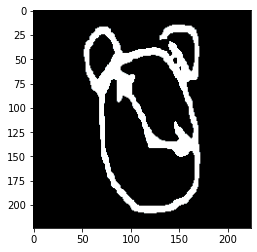

In [ ]:
print(doodleTrainDataset.getNumOfClasses())
print(len(doodleTrainDataset))
img, label = doodleTrainDataset.__getitem__(0)
visImg = img.permute(1,2,0).numpy()
plt.imshow(visImg)
print(label)
print(img)
print(img.shape)

In [ ]:
doodleTrainDatasetLoader = data.DataLoader(doodleTrainDataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
doodleTestDatasetLoader = data.DataLoader(doodleTestDataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(doodleNet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

## Training Loop

In [ ]:
totalEpoch = 5
bestAccuracy = 0

#pretrainNet.load_state_dict(torch.load('/content/drive/Shareddrives/ComputerVision/doodleDataset/modelCheckpoint' + 'bestModel' +"_epoch_"+str(4)+'.pth'))

for currentEpoch in range(0, totalEpoch):
  #### Train Phase ####
  print('='*10)
  print('Epoch :',currentEpoch)
  print('='*10)
  doodleNet.train()
  trainingLoss = 0.0
  correctImages = 0
  totalImages = 0
  trainingProgressbar = tqdm(enumerate(doodleTrainDatasetLoader), total=len(doodleTrainDatasetLoader), ncols='100%')
  for batchIdx, batchData in trainingProgressbar:
    images, labels = batchData
    images, labels = images.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = doodleNet(images)
    loss = criterion(outputs, labels)
    
    _, predicted = torch.max(outputs, 1)
    correctImages += (predicted == labels).sum().item()
    totalImages += labels.size(0)
    
    loss.backward()
    optimizer.step()
      

    trainingLoss += loss.item()
    accumulateAccuracy = round((correctImages/totalImages)*100,4)
    trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )

  # Learning rate scheduler stepping
  averageTrainingLoss = trainingLoss/len(doodleTrainDatasetLoader)
  scheduler.step(averageTrainingLoss)


  #### Test Phase ####
  doodleNet.eval()
  testLoss = 0.0
  correctImages = 0
  totalImages = 0
  testProgressbar = tqdm(enumerate(doodleTestDatasetLoader), total=len(doodleTestDatasetLoader), ncols='100%')
  for batchIdx, batchData in testProgressbar:
    with torch.no_grad():
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = doodleNet(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )


  testAccuracy = correctImages/totalImages

  
  if testAccuracy > bestAccuracy:
    print('='*10)
    print('Accuracy updated from', bestAccuracy,'to', testAccuracy)
    print('='*10)
    bestAccuracy = testAccuracy
    bestNet = doodleNet
  torch.save(doodleNet.state_dict(), '/content/drive/Shareddrives/ComputerVision/modelCheckpoint/' + 'lastCheckpointModel' +"_epoch_"+str(currentEpoch)+'.pth')

Epoch : 0



Accuracy updated from 0 to 0.916838751261751
Epoch : 1



Accuracy updated from 0.916838751261751 to 0.9218492709207438
Epoch : 2



Accuracy updated from 0.9218492709207438 to 0.9244226349009449
Epoch : 3



Accuracy updated from 0.9244226349009449 to 0.9258722803945176
Epoch : 4



Accuracy updated from 0.9258722803945176 to 0.9261118610675325


# 5.Continue ur Train everytime with this block

In [ ]:
doodleNet.load_state_dict(torch.load('/content/drive/Shareddrives/ComputerVision/modelCheckpoint/'  + 'checkPointModel' +"_epoch_"+str(3)+'.pth'))
torch.backends.cudnn.benchmark = True

train_transformations  = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [ ]:
doodleTrainDataset = doodleDataset(datasetDict=train_dataset_dict
                             ,categories=categories
                             ,classes_to_index=classes_to_index
                             ,index_to_class=index_to_class
                             ,transformations=train_transformations)

doodleTestDataset = doodleDataset(datasetDict=test_dataset_dict
                             ,categories=categories
                             ,classes_to_index=classes_to_index
                             ,index_to_class=index_to_class
                             ,transformations=train_transformations)

In [ ]:
doodleTrainDatasetLoader = data.DataLoader(doodleTrainDataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
doodleTestDatasetLoader = data.DataLoader(doodleTestDataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(doodleNet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [ ]:
totalEpoch = 10
bestAccuracy = 0.9287265797959003


for currentEpoch in range(4, totalEpoch):
  #### Train Phase ####
  doodleNet.train()
  trainingLoss = 0.0
  correctImages = 0
  totalImages = 0
  trainingProgressbar = tqdm(enumerate(doodleTrainDatasetLoader), total=len(doodleTrainDatasetLoader), ncols='100%')
  for batchIdx, batchData in trainingProgressbar:
    images, labels = batchData
    images, labels = images.cuda(), labels.cuda()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = doodleNet(images)
    loss = criterion(outputs, labels)
    
    _, predicted = torch.max(outputs, 1)
    correctImages += (predicted == labels).sum().item()
    totalImages += labels.size(0)
    
    loss.backward()
    optimizer.step()
      

    trainingLoss += loss.item()
    accumulateAccuracy = round((correctImages/totalImages)*100,4)
    trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )

  # Learning rate scheduler stepping
  averageTrainingLoss = trainingLoss/len(doodleTrainDatasetLoader)
  scheduler.step(averageTrainingLoss)


  #### Test Phase ####
  doodleNet.eval()
  testLoss = 0.0
  correctImages = 0
  totalImages = 0
  testProgressbar = tqdm(enumerate(doodleTestDatasetLoader), total=len(doodleTestDatasetLoader), ncols='100%')
  for batchIdx, batchData in testProgressbar:
    with torch.no_grad():
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = doodleNet(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )


  testAccuracy = correctImages/totalImages

  
  if testAccuracy > bestAccuracy:
    print('='*10)
    print('Accuracy updated from', bestAccuracy,'to', testAccuracy)
    print('='*10)
    bestAccuracy = testAccuracy
    bestNet = doodleNet
    torch.save(bestNet.state_dict(), '/content/drive/Shareddrives/ComputerVision/modelCheckpoint/' + 'checkPointModel' +"_epoch_"+str(currentEpoch)+'.pth')


Accuracy updated from 0.9287265797959003 to 0.9301853294052881



Accuracy updated from 0.9301853294052881 to 0.9311137511509576



Accuracy updated from 0.9311137511509576 to 0.9318939316433831


# Export to ONNX

In [ ]:
# doodleNet = models.mobilenet_v2(pretrained=True)
# doodleNet.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=False),
#     nn.Linear(in_features=1280, out_features=30, bias=True)
# )
dummy_input = torch.randn(1, 3, 224, 224)
doodleNet.cpu()
#doodleNet.load_state_dict(torch.load('/content/drive/Shareddrives/ComputerVision/doodleDataset/'  + 'bestModel' +"_epoch_"+str(9)+'.pth'))
#doodleNet.load_state_dict(torch.load('/content/drive/Shareddrives/ComputerVision/modelCheckpoint/'  + 'checkPointModel' +"_epoch_"+str(6)+'.pth'))
doodleNet.eval()
torch.onnx.export(doodleNet, dummy_input, "/content/drive/Shareddrives/ComputerVision/modelCheckpoint/50-doodleNet-v4-final.onnx",
                  verbose=False,
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=7,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'] )

In [ ]:
from sklearn.metrics import confusion_matrix